# Visualising field using `matplotlib`

There are two ways how a field can be visualised, using:

- `matplotlib`
-`k3d`

`matplotlib` provides two-dimensional plots of fields. This means that the field can be visualised only if was firstly intersected with a plane.

Let us say we have a sample, which is a nanocylinder of diametre $30\,\text{nm}$ and $50 \,\text{nm}$ height. The value of the field at $(x, y, z)$ point is $(-cy, cx, cz)$, with $c=10^{9}$. The norm of the field inside the cylinder is $10^{6}$.

Let us firstly build that field. We start by creating a rectangular mesh which can contain the cylinder we described.

In [1]:
import discretisedfield as df
import matplotlib.pyplot as plt

p1 = (-15e-9, -15e-9, -25e-9)
p2 = (15e-9, 15e-9, 25e-9)
cell = (1e-9, 1e-9, 1e-9)
mesh = df.Mesh(p1=p1, p2=p2, cell=cell)

Secondly, we want to define the norm. When we define the nanocylinder, the norm of the vector field outside the cylinder should be zero and inside $M_\text{s}$. The Python function is

In [2]:
def norm_fun(pos):
    x, y, z = pos
    if x**2 + y**2 < (15e-9)**2:
        return 1e6
    else:
        return 0

The Python function which defines the spatially varying field inside the cylinder is

In [3]:
def value_fun(pos):
    x, y, z = pos
    c = 1e9
    return (-c*y, c*x, c*z)

Now, we can create the field.

In [4]:
field = df.Field(mesh, dim=3, value=value_fun, norm=norm_fun)
vortex_field = field

## Plotting using `Field.mpl()`
The main function used to visualise the field using `matplotlib` is `discertisedfield.Field.mpl`. Let us try to run it.

In [5]:
try:
    field.mpl()
except ValueError as e:
    print('Exception raised:', e)

Exception raised: The field must be sliced before it can be plotted.


The exception was raised because `matplotlib` plotting is available only for two-dimensional planes. Therefore, we have to first intersect the field with a plane and then plot it. Let us intersect it with $z=10\,\mathrm{nm}$ plane and then call the `mpl` method.

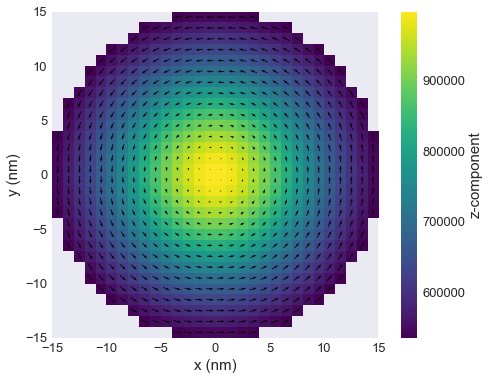

In [6]:
# NBVAL_IGNORE_OUTPUT
field.plane(z=10e-9).mpl()

The figure is probably too small to see the interesting features of the field we defined. Therefore, we can make it larger by passing `figsize` argument.

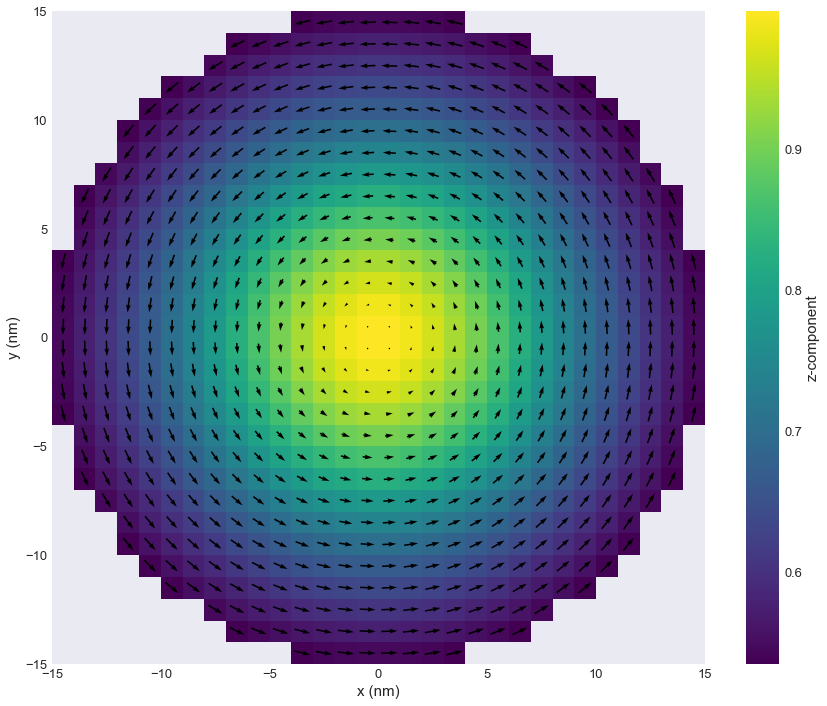

In [7]:
# NBVAL_IGNORE_OUTPUT
field.orientation.plane(z=10e-9).mpl(figsize=(15, 12))

Now, we can see that we plotted the $z$-plane intersection by looking at the $x$ and $y$ dimensions on the horizontal and vertical axes, respectively. Secondly, we see that there are two overlapped plots: a coloured plot (`scalar`) and a vector plot (`vector`). `vector` plot can only plot two-dimensional vector fields. More precisely, it plots the projection of a vector on the plane we intersected the field with. However, we then lose the information about the out-of-plane component of the vector field. Because of that, there is a scalar (`scalar`) field, together with a colorbar, whose colour depicts the $z$ component of the field. We can also notice, that all discretisation cells where the norm of the field is zero, are not plotted.

Similarly, we can plot a different plane

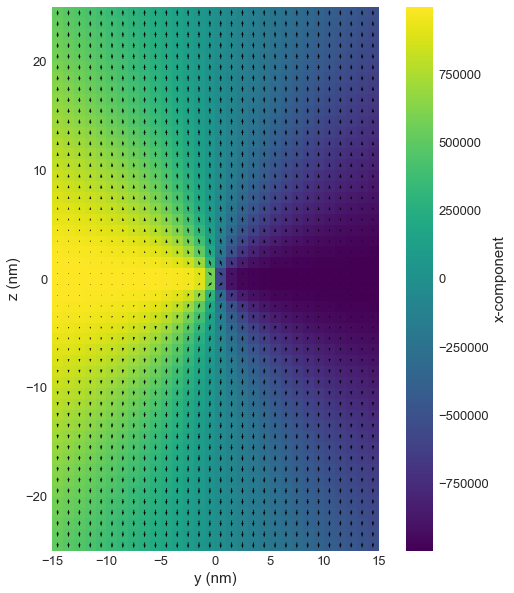

In [8]:
# NBVAL_IGNORE_OUTPUT
field.plane('x').mpl(figsize=(10, 10))

If there are too many discretisation cells on the plot, their number can decreased by passing `n` argument to the `plane` method.

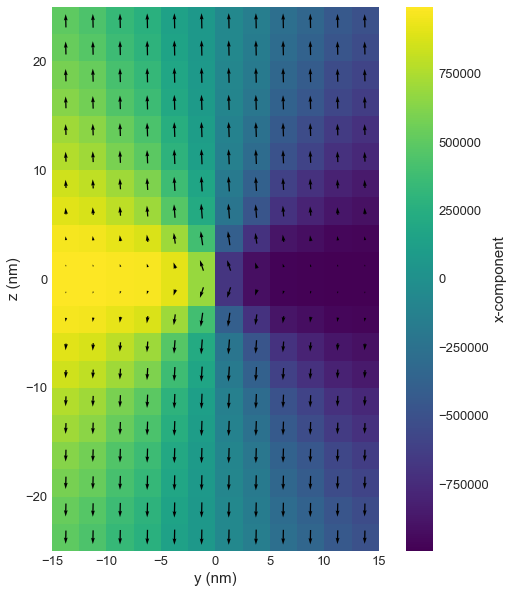

In [9]:
# NBVAL_IGNORE_OUTPUT
field.plane('x', n=(12, 20)).mpl(figsize=(10, 10))

## Available plotting functions

So far, we showed the default behaviour of `discretisedfield.Field.mpl()`, a convenience function for simple plots. However, it is often required that a custom plot is built. Here, we show the different available plotting functions:

- `discretisedfield.Field.mpl.scalar` for plotting scalar fields
- `discretisedfield.Field.mpl.vector` for plotting vector fields
- `discretisedfield.Field.mpl.contour` for plotting contour lines of scalar fields
- `discretisedfield.Field.mpl.lightness` for HSL plots of scalar or vector fields

`discretisedfield.Field.mpl()` internally combines `discretisedfield.Field.mpl.scalar` and `discretisedfield.Field.mpl.vector`.

In the following we will always plot the field on one of two different planes. To simplify the subsequent calls we first define the planes.

In [10]:
plane_xy = field.plane(z=10e-9)
plane_yz = field.plane('x', n=(12,20))

### Scalar field visualisation – `mpl.scalar`

First, we simply try to plot the full field using `mpl.scalar`:

In [11]:
try:
    plane_xy.mpl.scalar()
except ValueError as e:
    print('Exception raised:', e)

Exception raised: Cannot plot self.field.dim=3 field.


An exception was raised because `mpl.scalar` can only plot scalar fields. Therefore, we are going to extract the $z$ component of the field.

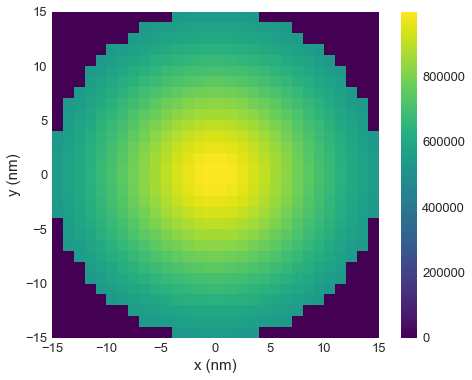

In [12]:
plane_xy.z.mpl.scalar()

Now, we got a plot of the field's $z$ component. However, discretisation cells, which are outside the cylinder, are also plotted. This is because norm cannot be reconstructed from the scalar field passed to `mpl.scalar`. In order to remove the cells where field is zero from the plot, `filter_field` must be passed. 

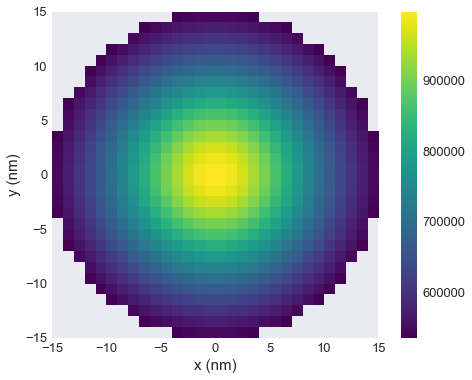

In [13]:
plane_xy.z.mpl.scalar(filter_field=field.norm)

Colorbar is added to the plot by default. However, we can remove it from the plot.

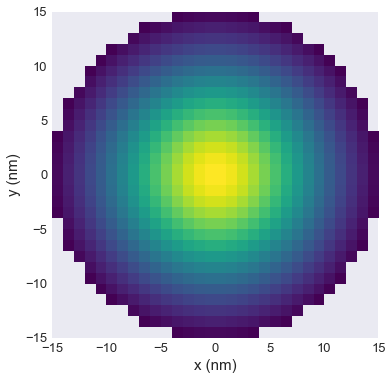

In [14]:
plane_xy.z.mpl.scalar(filter_field=field.norm, colorbar=False)

Similarly, we can change the colorbar label.

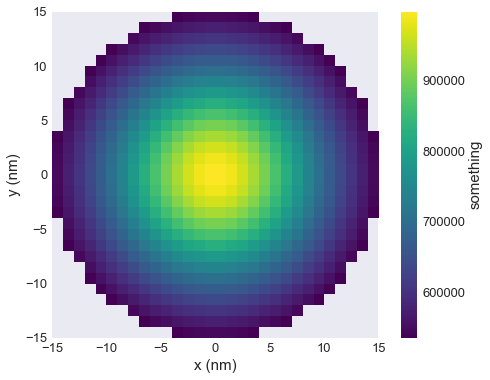

In [15]:
plane_xy.z.mpl.scalar(filter_field=field.norm, colorbar_label='something')

As already seen, we can change the size of the plot.

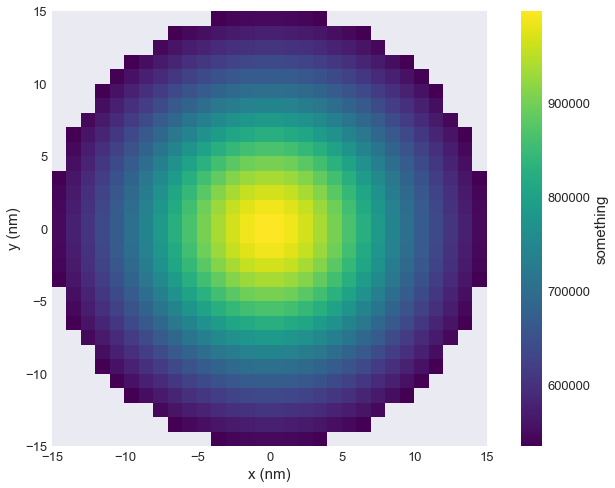

In [16]:
plane_xy.z.mpl.scalar(figsize=(12,8), filter_field=field.norm, colorbar_label='something')

Sometimes it is necessary to adjust the limits on the colorbar:

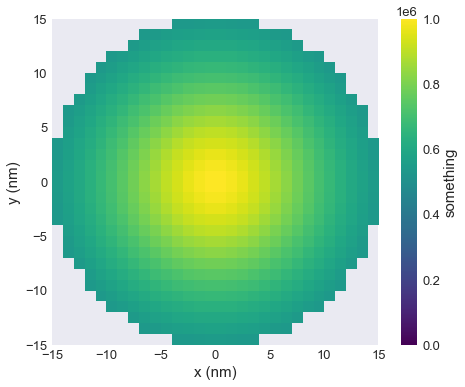

In [17]:
plane_xy.z.mpl.scalar(filter_field=field.norm, colorbar_label='something', clim=(0, 1e6))

If we have data (symmetrically) arround zero it can be useful to have a symmetric colour bar, i.e. to asign the value zero to the central color. We can do this (without specifying limits manually) by passing `symmetric_clim`. 

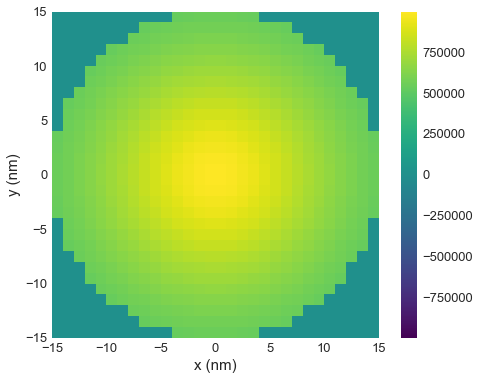

In [18]:
plane_xy.z.mpl.scalar(symmetric_clim=True)

Multiplier used for axis labels is computed internally, but it can be explicitly changed using `multiplier`.

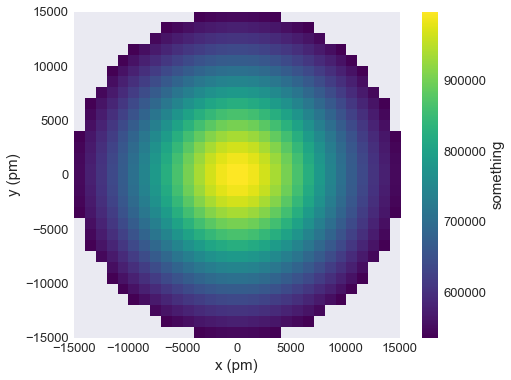

In [19]:
plane_xy.z.mpl.scalar(filter_field=field.norm, colorbar_label='something', multiplier=1e-12)

In order to save the plot, we pass `filename` and the plot is saved as PDF.

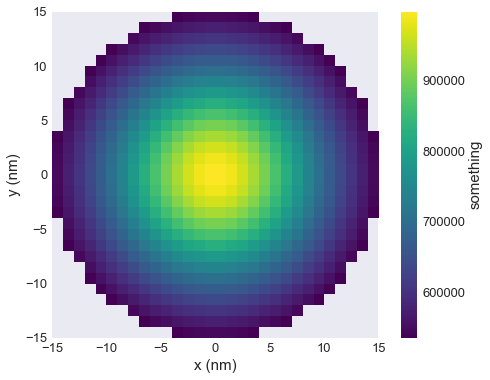

In [20]:
plane_xy.z.mpl.scalar(filter_field=field.norm, colorbar_label='something', filename='scalar.pdf')

`mpl_scalar` is based on `matplotlib.pyplot.imshow`, so any argument accepted by it can be passed. For its functionality, please refer to the [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html). The available colormaps and additional information on the use of colormaps are shown in this [matplotlib tutorial](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

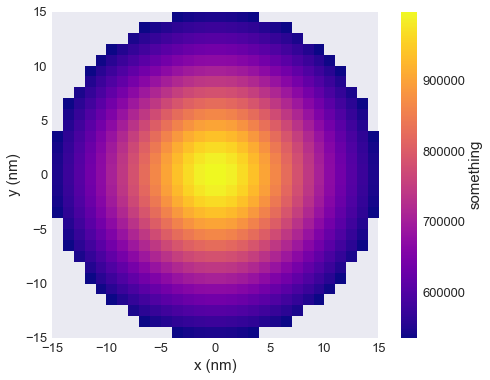

In [21]:
plane_xy.z.mpl.scalar(filter_field=field.norm, colorbar_label='something', cmap='plasma')

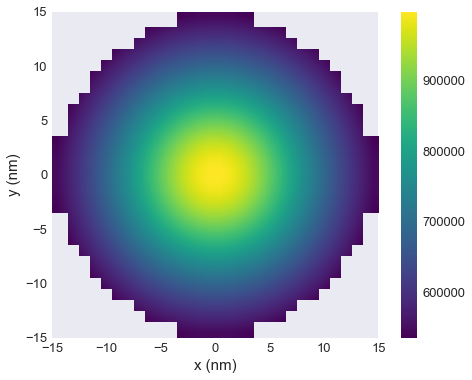

In [22]:
plane_xy.z.mpl.scalar(filter_field=field.norm, interpolation='bilinear')

### Vector field visualisation – `mpl.vector`
The default plot is:

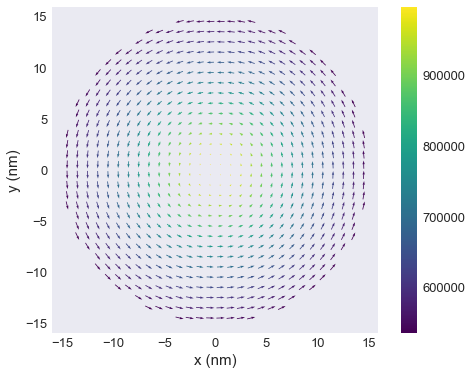

In [23]:
plane_xy.mpl.vector()

By default color is used to show the out-of-plane component. We can reduce the number of vectors.

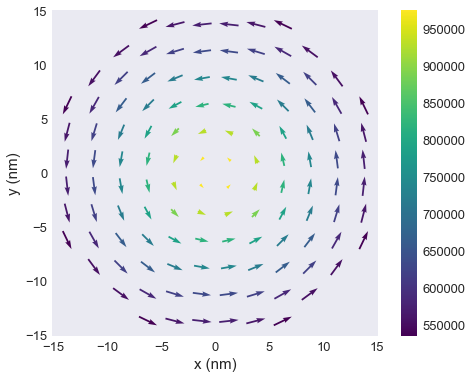

In [24]:
field.plane(z=10e-9, n=(12,12)).mpl.vector()

We can turn of automatic coloring based on one vector component.

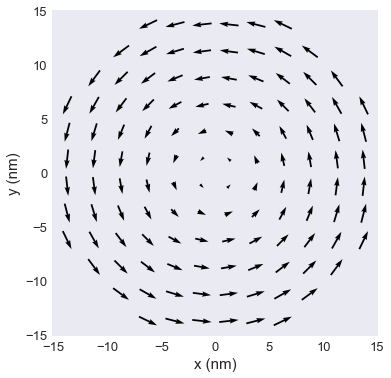

In [25]:
field.plane(z=10e-9, n=(12,12)).mpl.vector(use_color=False)

Without automatic colouring, we can additionally specify a uniform color.

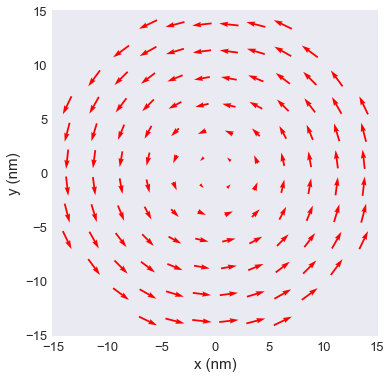

In [26]:
field.plane(z=10e-9, n=(12,12)).mpl.vector(color='red', use_color=False)

Turn of colorbar.

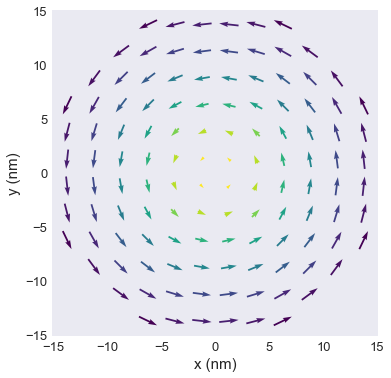

In [27]:
field.plane(z=10e-9, n=(12,12)).mpl.vector(colorbar=False)

Use a different scalar field for coloring.

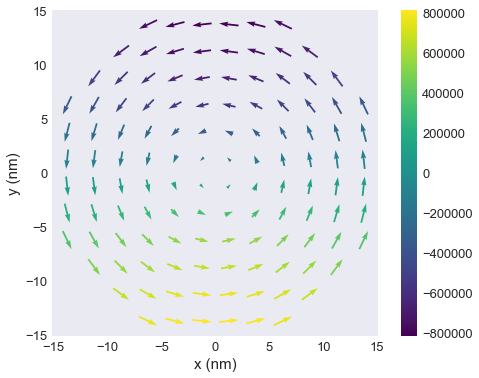

In [28]:
field.plane(z=10e-9, n=(12,12)).mpl.vector(color_field=field.x)

Similar to `mpl.scalar` we can 

- add a colourbar label,
- change the colormap,
- change the colormap limit,
- change the multiplier,
- change the figure size,
- and save the plot.

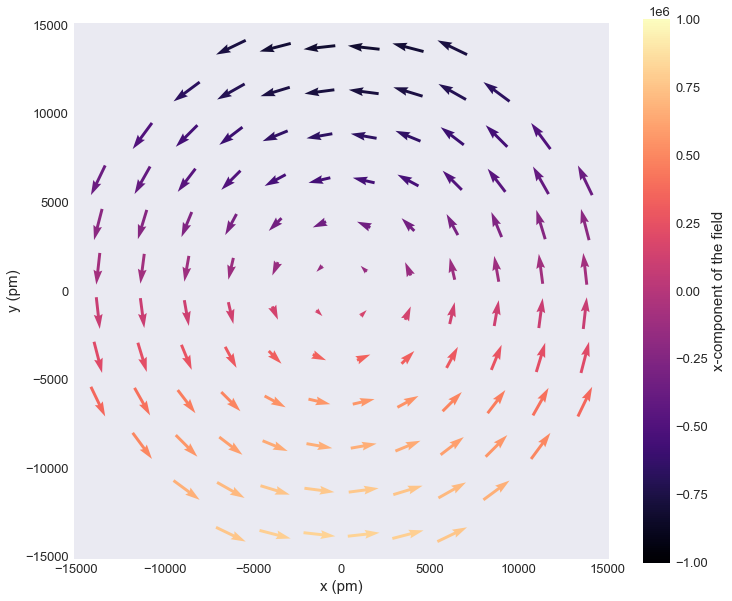

In [29]:
field.plane(z=10e-9, n=(12,12)).mpl.vector(color_field=field.x,
                                           colorbar_label='x-component of the field',
                                           cmap='magma',
                                           clim=(-1e6, 1e6),
                                           multiplier=1e-12,
                                           figsize=(12,10),
                                           filename='vector.pdf')

We can pass additional keyword arguments to change the quiver style (see `matplotlib.pyplot.quiver` [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html) for details and available arguments).

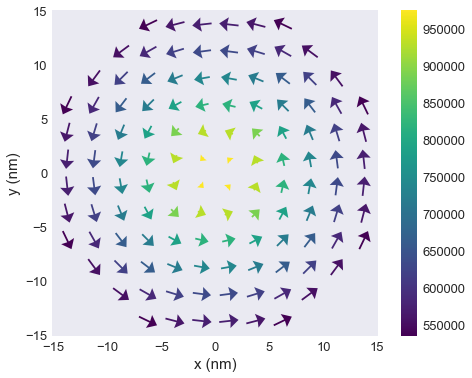

In [30]:
field.plane(z=10e-9, n=(12, 12)).mpl.vector(headwidth=8)

Scale of quivers.

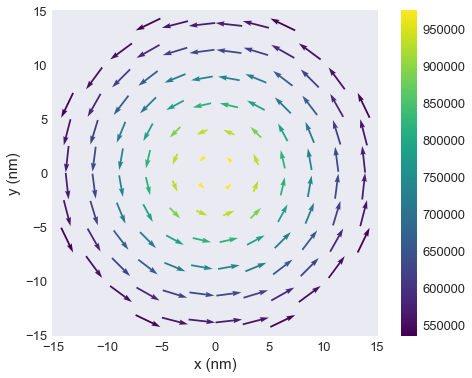

In [31]:
field.plane(z=10e-9, n=(12,12)).mpl.vector(scale=1e7)

### Contour line plots – `mpl.contour`
Scalar fields can be plotted as contour line plots.

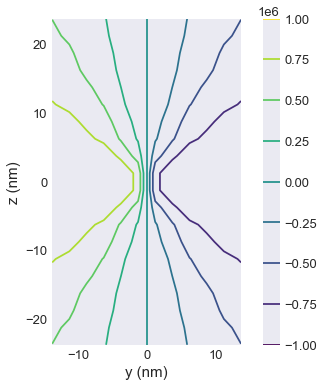

In [32]:
plane_yz.x.mpl.contour()

Similar to `mpl.scalar` it is possible to
- change the `figsize`
- specify a `multiplier`
- specify a `filter_field`
- save the figure by passing `filename`
- control `colorbar` and `colorbar_label`.

Additional keyword arguments can be passed, as `mpl.contour` is based on `matplotlib.pyplot.contour` ([documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html)).

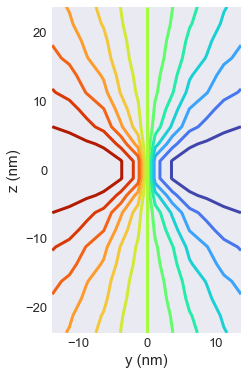

In [33]:
plane_yz.x.mpl.contour(levels=15, cmap='turbo', colorbar=False, linewidths=3)

### HSL plots – `mpl.lightness`

A common way to plot full vector fields is to use the HSV/HSL color scheme. The angle of the in-plane component is then shown by colour, the out-of-plane component by the lightness.

`mpl.lighness` can be used for fields with `dim=1`, `dim=2`, or `dim=3`. For `dim=3` vector fields the out-of-plane component is used for the lightness, otherwise the `norm` is used by default.

_NOTE: `filter_field` is currently not supported, specifying this option has no effect._

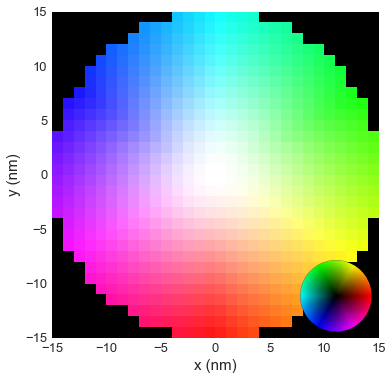

In [34]:
plane_xy.mpl.lightness()

Similar to `mpl.scalar` it is possible to
- change the `figsize`
- specify a `multiplier`
- ~specify a `filter_field`~
- save the figure by passing `filename`.

Instead of a `colorbar` a colorwheel is shown by default. It is possible to show additional labels.

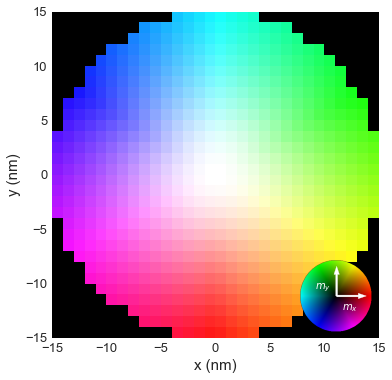

In [35]:
plane_xy.mpl.lightness(colorwheel_xlabel=r'$m_x$', colorwheel_ylabel=r'$m_y$')

Not showing the `colorwheel`.

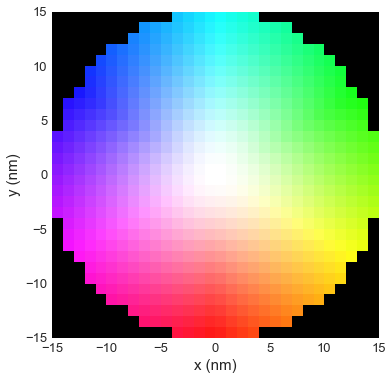

In [36]:
plane_xy.mpl.lightness(colorwheel=False)

Specifying a different `lighness_field` (suffering from the missing `filter_field` option).

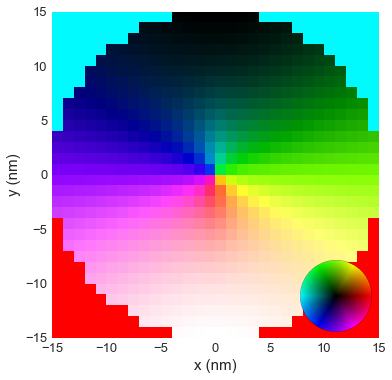

In [37]:
plane_xy.mpl.lightness(lightness_field=field.x)

Change the lightness range.

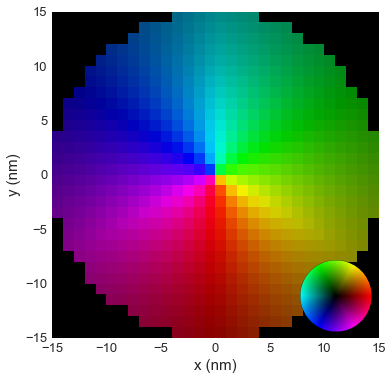

In [38]:
plane_xy.mpl.lightness(clim=(0, 0.5))

#### `colorwheel`
We can pass additional keyword arguments to `colorwheel_args` in the `lighness` plot.

To get more control over the colorwheel the function to draw the colorwheel is exposed an can be used separatly. We have to explicitly give an axis to `add_colorwheel`.

<AxesHostAxes:>

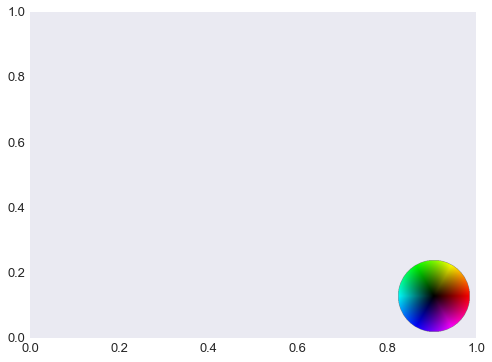

In [39]:
fig, ax = plt.subplots()
df.plotting.mpl.add_colorwheel(ax=ax)

We can specify `widht`, `height`, `loc` and additional keyword arguments that can be used for `mpl_toolkits.axes_grid1.inset_locator.inset_axes` ([documentation](https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.axes_grid1.inset_locator.inset_axes.html)).

<AxesHostAxes:>

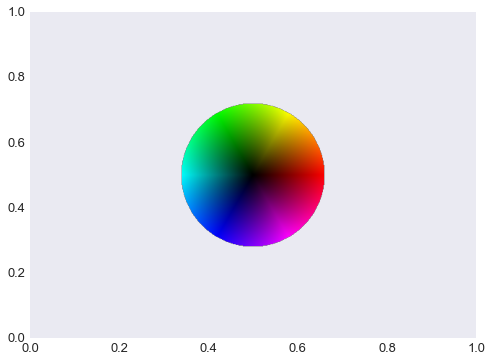

In [40]:
fig, ax = plt.subplots()
df.plotting.mpl.add_colorwheel(ax, width=2, height=2, loc='center')

### Combining scalar and vector plots – `mpl()`

In the beginning, we have briefly seen, that we can use the convenience function `mpl()` to generate plots. We can adjust these plots by passing `scalar_kwargs` or `vector_kwargs` that are internally passed to `mpl.scalar` and `mpl.vector`, respectivly. All arguments allowed for `mpl.scalar` or `mpl.vector` can be specified. By default `use_color=False` for the quiver plot.

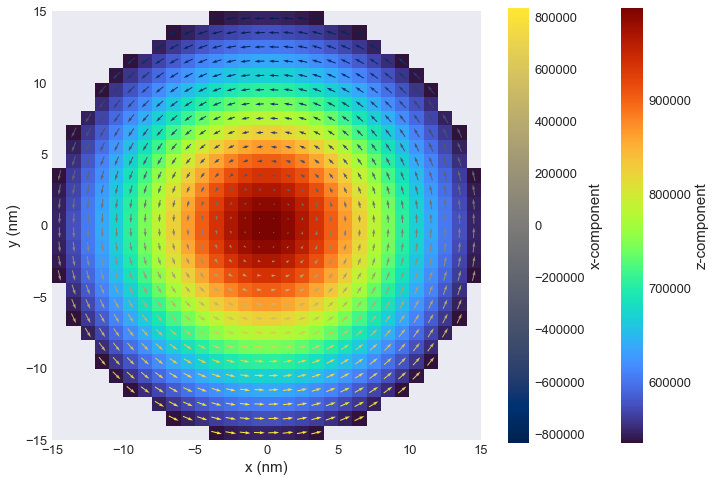

In [41]:
plane_xy.mpl(figsize=(12,8),
             scalar_kwargs={'cmap': 'turbo'},
             vector_kwargs={'cmap': 'cividis', 'use_color': True, 'color_field': field.x, 'colorbar': True,
                            'colorbar_label': 'x-component'},
             multiplier=1e-9,
             #filename='mplplot.pdf'
            )

## Building a custom plot
We can build custom plots by combining the different available plots. This is done via passing axes to the plotting functions. In the following we start with a step-by-step example and then show some additional examples.

First, we manually create the combined `scalar`-`vector` plot similar to the one show in the cell above. We start by creating figure and axes.

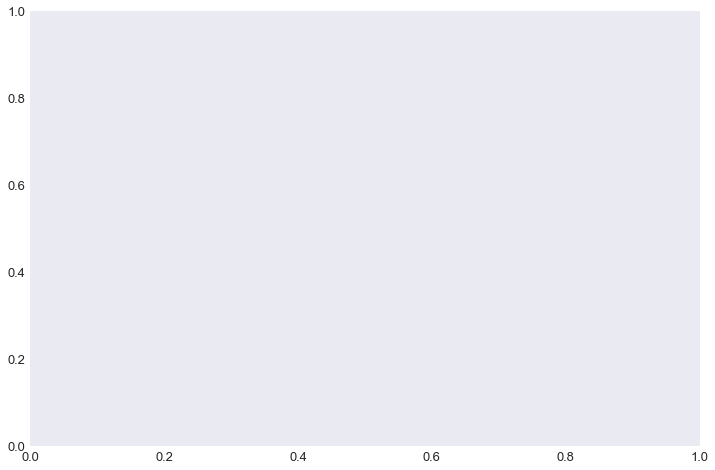

In [42]:
fig, ax = plt.subplots(figsize=(12,8))

Then we can add the scalar plot of the z-component and pass `ax` as additional argument. We have to manually specify the `filter_field`.

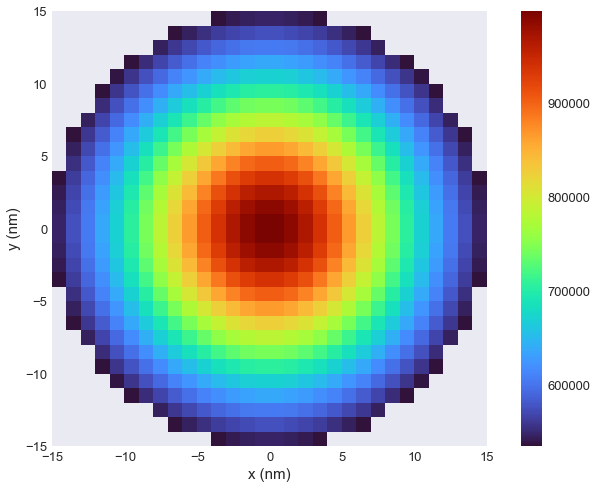

In [43]:
fig, ax = plt.subplots(figsize=(12,8))
field.plane(z=10e-9).z.mpl.scalar(ax=ax, cmap='turbo', filter_field=field.norm)

In the last step we can add the quiver plot using `mpl.vector`. As we now have separate control over `scalar` and `vector` we can reduce the number of `quivers` independently.

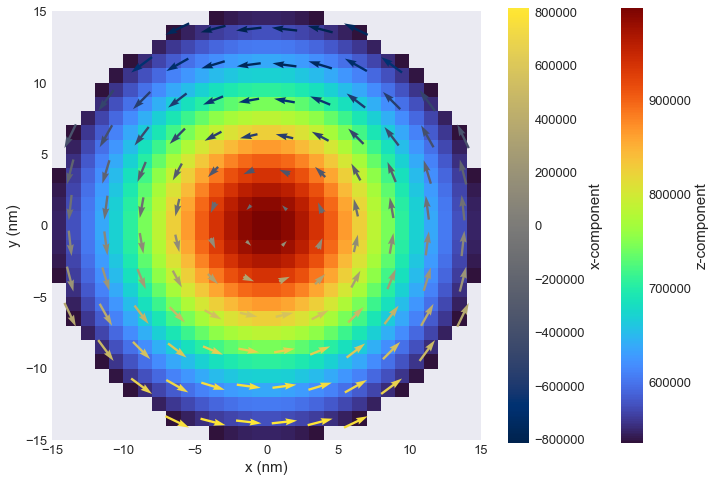

In [44]:
fig, ax = plt.subplots(figsize=(12,8))
field.plane(z=10e-9).z.mpl.scalar(ax=ax, cmap='turbo', filter_field=field.norm, colorbar_label='z-component')
field.plane(z=10e-9, n=(12, 12)).mpl.vector(ax=ax, cmap='cividis', color_field=field.x, colorbar_label='x-component')

We can combine different plots in different subplots.

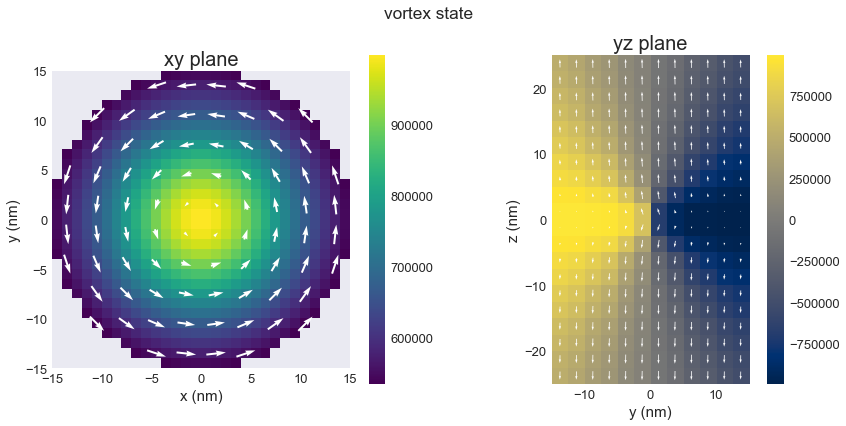

In [45]:
fig, axs = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
plane_xy.z.mpl(ax=axs[0])
field.plane(z=10e-9, n=(10,10)).mpl.vector(ax=axs[0], use_color=False, color='white')
plane_yz.mpl(ax=axs[1], scalar_kwargs={'colorbar_label': None, 'cmap': 'cividis', 'symmetric_clim': True},
             vector_kwargs={'color': 'white'})
axs[0].set_title('xy plane');
axs[1].set_title('yz plane');
fig.suptitle('vortex state', fontsize='xx-large')
fig.tight_layout()

By exposing axes we can also combine the other plotting functions, e.g. `lightness`, `vector` and `contour`. We use a new field to show this functionality.

In [46]:
import numpy as np

def init_m(p):
    x, y, z = p
    return np.sin(x/4), np.cos(y/5), z/5

mesh = df.Mesh(p1=(0,0,0), p2=(40,40,10), cell=(1,1,1))
field = df.Field(mesh, dim=3, value=init_m, norm=1)#init_norm)

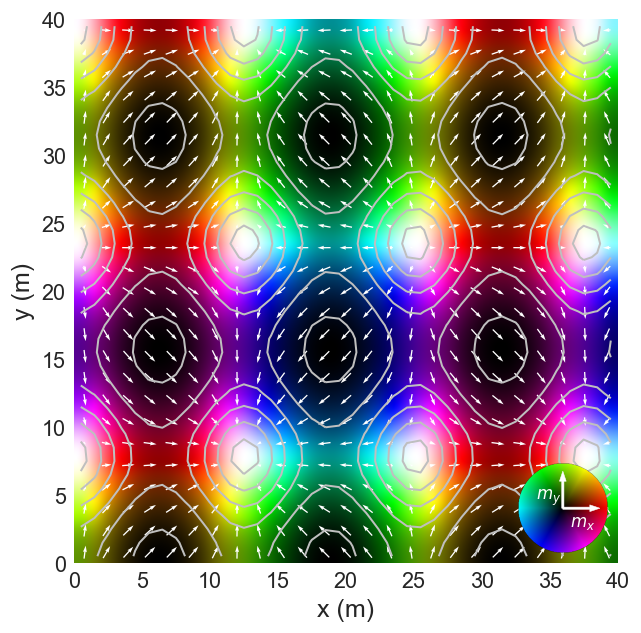

In [47]:
fig, ax = plt.subplots(dpi=120)
field.plane('z').mpl.lightness(ax=ax, interpolation='spline16', colorwheel_args=dict(width=.75, height=.75),
                               colorwheel_xlabel=r'$m_x$', colorwheel_ylabel=r'$m_y$')
field.plane('z', n=(25, 25)).mpl.vector(ax=ax, use_color=False, color='w')
field.plane('z').z.mpl.contour(ax=ax, levels=6, colors='#bfbfbf', colorbar=False, linewidths=1.2)

## Interactive plots
We can create interactive plots based on `Ipython Widgets`. We define a new field to demonstrate the different interactive plots.

In [48]:
p1 = (-5e-9, -5e-9, -2e-9)
p2 = (5e-9, 5e-9, 10e-9)
cell = (1e-9, 1e-9, 1e-9)
mesh = df.Mesh(p1=p1, p2=p2, cell=cell)

value_fun = lambda pos: (pos[0], pos[1], pos[2])

def norm_fun(pos):
    x, y, z = pos
    if x**2 + y**2 < 5e-9**2:
        return 1
    else:
        return 0
    
field = df.Field(mesh, dim=3, value=value_fun, norm=norm_fun)

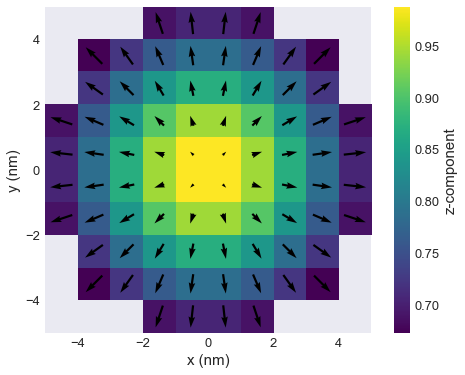

In [49]:
field.plane('z').mpl()

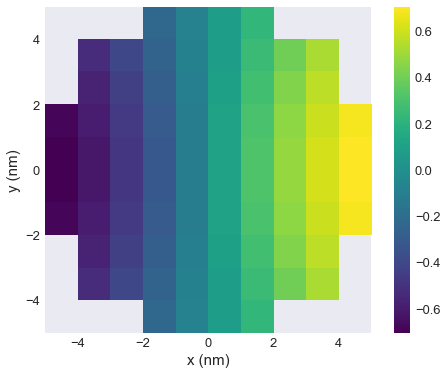

In [50]:
field.x.plane('z').mpl()

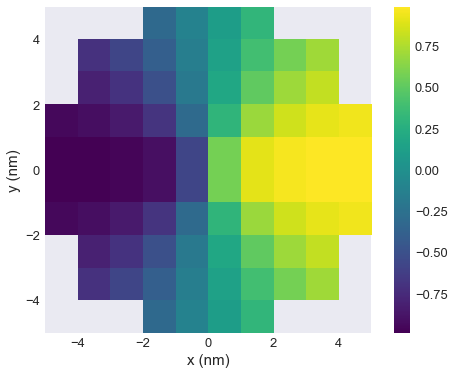

In [51]:
field.x.plane(z=0).mpl()

_NOTE_:

- Interactive plots cannot be displayed on the static website
- Widgets work best in Jupyter notebook. Inside Jupyter lab, if the plot does not update correctly, try adding `mpl.show()` at the end of the function.

interactive(children=(SelectionSlider(description='z (nm)', index=6, options=((-1.5, -1.5000000000000002e-09),…

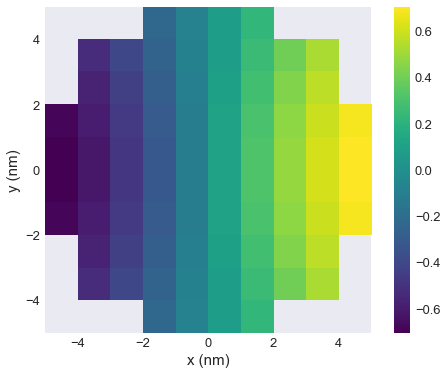

In [52]:
@df.interact(z=field.mesh.slider('z'))
def myplot(z):
    field.x.plane(z=z).mpl()

interactive(children=(SelectionSlider(continuous_update=False, description='z (nm)', index=6, options=((-1.5, …

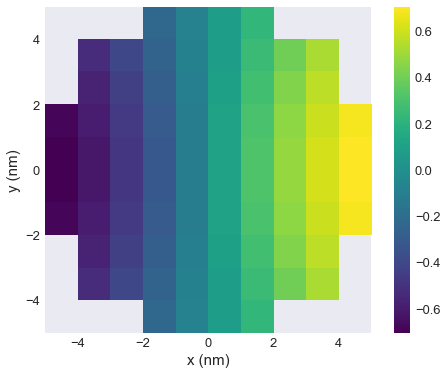

In [53]:
@df.interact(z=field.mesh.slider('z', continuous_update=False))
def myplot(z):
    field.x.plane(z=z).mpl()

interactive(children=(SelectionSlider(continuous_update=False, description='z (nm)', index=6, options=((-1.5, …

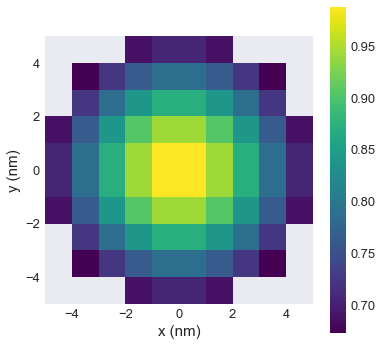

In [54]:
@df.interact(z=field.mesh.slider('z', continuous_update=False),
             component=field.mesh.axis_selector())
def myplot(z, component):
    getattr(field, component).plane(z=z).mpl(figsize=(6, 6))

interactive(children=(SelectionSlider(continuous_update=False, description='z (nm)', index=6, options=((-1.5, …

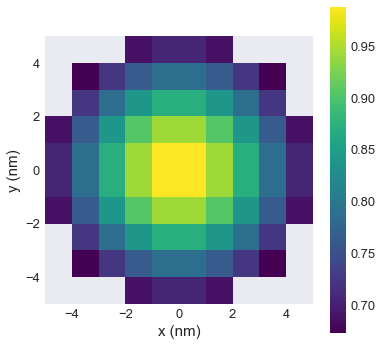

In [55]:
@df.interact(z=field.mesh.slider('z', continuous_update=False),
             component=field.mesh.axis_selector(widget='radiobuttons', description='component'))
def myplot(z, component):
    getattr(field, component).plane(z=z).mpl(figsize=(6, 6))

interactive(children=(SelectionSlider(continuous_update=False, description='z (nm)', index=6, options=((-1.5, …

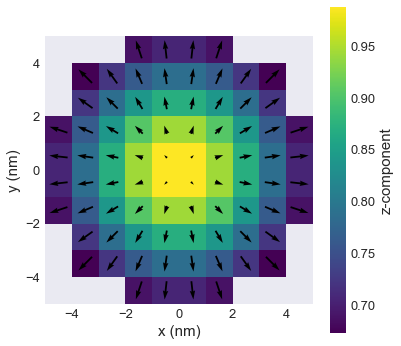

In [56]:
@df.interact(z=field.mesh.slider('z', continuous_update=False))
def myplot(z):
    field.plane(z=z).mpl(figsize=(6, 6))

## Plotting field values along the line

Sometimes it is necessary to explore the field values along a certain line. More precisely, to plot the field values along a line defined between two points. We again use the vortex field. Firstly, we need to obtain $z$ values of the field on a line between $(-15\,\mathrm{nm}, 0, 0)$ and $(15\,\mathrm{nm}, 0, 0)$ at $n=20$ points.

In [57]:
line = vortex_field.mesh.line(p1=(-15e-9, 0, 0), p2=(15e-9, 0, 0), n=20)
field_values = []
parameter = []
for point in line:
    x, y, z = point
    parameter.append(x)   # remember x-position for plot
    field_values.append(vortex_field(point))

# extract mx, my, mz as lists from lists of (mx, my, mz):
mx, my, mz = zip(*field_values)

Now, we can plot the field values along the line:

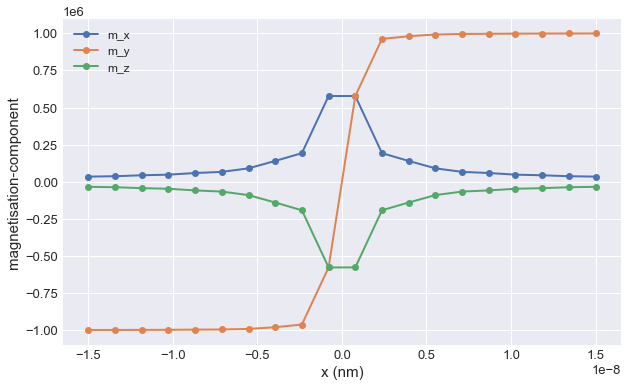

In [58]:
# NBVAL_IGNORE_OUTPUT
plt.figure(figsize=(10, 6))
plt.plot(parameter, mx, 'o-', linewidth=2, label='m_x')
plt.plot(parameter, my, 'o-', linewidth=2, label='m_y')
plt.plot(parameter, mz, 'o-', linewidth=2, label='m_z')
plt.xlabel('x (nm)')
plt.ylabel('magnetisation-component')
plt.grid()
plt.legend()